In [1]:
import ROOT
from OutFunc import OutFunc

In [ ]:
hBkg = ROOT.TH1D("hBkg", "BDT output; background", 100, -1.0, 1.0)

In [ ]:
# Set up the OutFunc object.  First argument must be one of the classifiers.
# 4th argument is offset for contour.
# 5th argument is bool array indicating which variables were used in training
dir = "dataset/weights/"
prefix = "tmvaTest"
name = "BDTcheck10"
tCut = 0.0
useVar = [False, True, True, True, True, True, True]

testStat = OutFunc(name, dir, prefix, tCut, useVar)

In [ ]:
def fill_histograms(input_path):
    inputFile = ROOT.TFile(input_path)
    bkg = inputFile.Get("bkg")

    numEntries = bkg.GetEntries()
    print(f"Total Entries: {numEntries}")

    for j in range(numEntries):
        bkg.GetEntry(j)
        t = testStat.val(bkg)
        hBkg.Fill(t)

    inputFile.Close()

In [ ]:
fill_histograms("trainData.root")
fill_histograms("testData.root")

In [ ]:
#Saving output histogram
hFile = ROOT.TFile("bkgHistoFit.root", "RECREATE")
hBkg.Write()
hFile.Close()

Fitting from x = -0.35 to x = 1.0
Integral of fit from x = 0.32525 to x = 1.0 is 7.409505843591844
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =  5.03999e+06
NDf                       =           31
Edm                       =  1.37046e-07
NCalls                    =          300
p0                        =      19490.1   +/-   11.1301     
p1                        =       15.738   +/-   0.00175547  


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


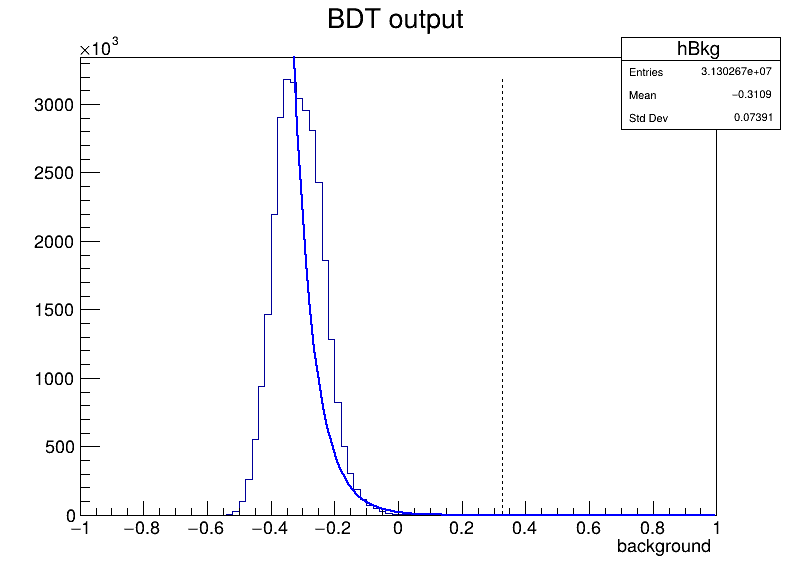

In [4]:
# Input parameters
x_cut = 0.32525  # <-- Set this to your integration lower limit

# Load your histogram (assume TH1D named 'h')
f = ROOT.TFile.Open("bkgHistoFit.root")
h = f.Get("hBkg")  # replace with your TH1D name

# Step 1: Find maximum bin and its center
max_bin = h.GetMaximumBin()
x_start = h.GetBinCenter(max_bin)

# Step 2: Get right edge of histogram
x_end = h.GetXaxis().GetXmax()

print(f"Fitting from x = {x_start} to x = {x_end}")

# Step 3: Define exponential fit function
fit_func = ROOT.TF1("fit_func", "[0]*exp(-[1]*x)", x_start, x_end)
fit_func.SetParameters(1.0, 1.0)  # optional initial guesses

# Step 4: Fit the histogram
h.Fit(fit_func, "R")  # "R" = fit only in range


integral = fit_func.Integral(x_cut, x_end)

print(f"Integral of fit from x = {x_cut} to x = {x_end} is {integral}")

# Optional: Plot everything
canvas = ROOT.TCanvas("c", "Fit + Integral", 800, 600)
h.Draw("HIST")
fit_func.SetLineColor(ROOT.kBlue)
fit_func.Draw("same")
line = ROOT.TLine(x_cut, 0, x_cut, h.GetMaximum())
line.SetLineStyle(2)
line.Draw("same")
canvas.Update()


Fit params: A = 3421301.836, mu = -0.314, sigma = 0.072
Integral of extrapolated Gaussian from x = 0.32525 to 1.0: 0.0000
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =       257633
NDf                       =           12
Edm                       =  4.19786e-08
NCalls                    =           84
Constant                  =   3.4213e+06   +/-   786.487     
Mean                      =    -0.313764   +/-   1.76823e-05 
Sigma                     =    0.0717057   +/-   1.35943e-05  	 (limited)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


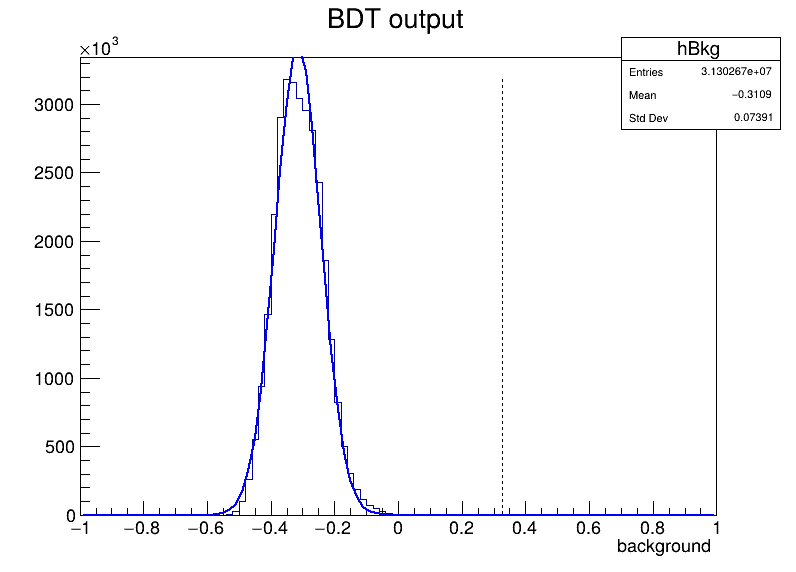

In [6]:
# === Load histogram ===
f = ROOT.TFile.Open("bkgHistoFit.root")
h = f.Get("hBkg")  # Replace with actual name

if not h or not h.InheritsFrom("TH1"):
    raise RuntimeError("Invalid histogram")

# === Peak fit ===
max_bin = h.GetMaximumBin()
peak_x = h.GetBinCenter(max_bin)
sigma_guess = h.GetRMS()

# Fit only around the peak
fit_min = peak_x - 2 * sigma_guess
fit_max = peak_x + 2 * sigma_guess

# Temporary function for fitting
fit_peak = ROOT.TF1("fit_peak", "gaus", fit_min, fit_max)
h.Fit(fit_peak, "R")

# Extract parameters
A     = fit_peak.GetParameter(0)
mu    = fit_peak.GetParameter(1)
sigma = fit_peak.GetParameter(2)

print(f"Fit params: A = {A:.3f}, mu = {mu:.3f}, sigma = {sigma:.3f}")

# === Create extrapolated full-range Gaussian ===
x_min = h.GetXaxis().GetXmin()
x_max = h.GetXaxis().GetXmax()

gaus_full = ROOT.TF1("gaus_full", "gaus", x_min, x_max)
gaus_full.SetParameters(A, mu, sigma)

# === Optional: integrate above a cut ===
x_cut = 0.32525  # example threshold
integral_tail = gaus_full.Integral(x_cut, x_max)
print(f"Integral of extrapolated Gaussian from x = {x_cut} to {x_max}: {integral_tail:.4f}")

# === Draw everything ===
canvas = ROOT.TCanvas("c2", "Extrapolated Gaussian Fit", 800, 600)
h.Draw("HIST")
gaus_full.SetLineColor(ROOT.kBlue)
gaus_full.Draw("same")

# Optional: line at cut
line = ROOT.TLine(x_cut, 0, x_cut, h.GetMaximum())
line.SetLineStyle(2)
line.SetLineColor(ROOT.kBlack)
line.Draw("same")

canvas.Update()